In [31]:
import sys
sys.path.append(".")

In [32]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pylab as plt
from pathlib import Path
from tensorflow.keras import layers

#from PlayingCardsGenerator import CardsDataGenerator
import datetime

In [33]:
model_name_it = "Outputs/Efficient_net_B0_it_52.h5"

In [34]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [35]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [36]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [37]:
def scheduler(epoch, lr):
    if epoch%30 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [38]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [39]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [40]:
log_dir = "Outputs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "rotation_range":90,\
              "width_shift_range":0.3,\
              "height_shift_range":0.3, \
              "shear_range":0.3, \
              "zoom_range":0.3,\
              "vertical_flip":True}

In [42]:
generator = ImageDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [43]:
bs = 16 # batch size

In [44]:
path = Path("dataset/")

In [45]:
img_height = 224
img_width = 224

In [74]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [55]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    shuffle = True,
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as training data

Found 24952 images belonging to 52 classes.


In [56]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as validation data

Found 6206 images belonging to 52 classes.


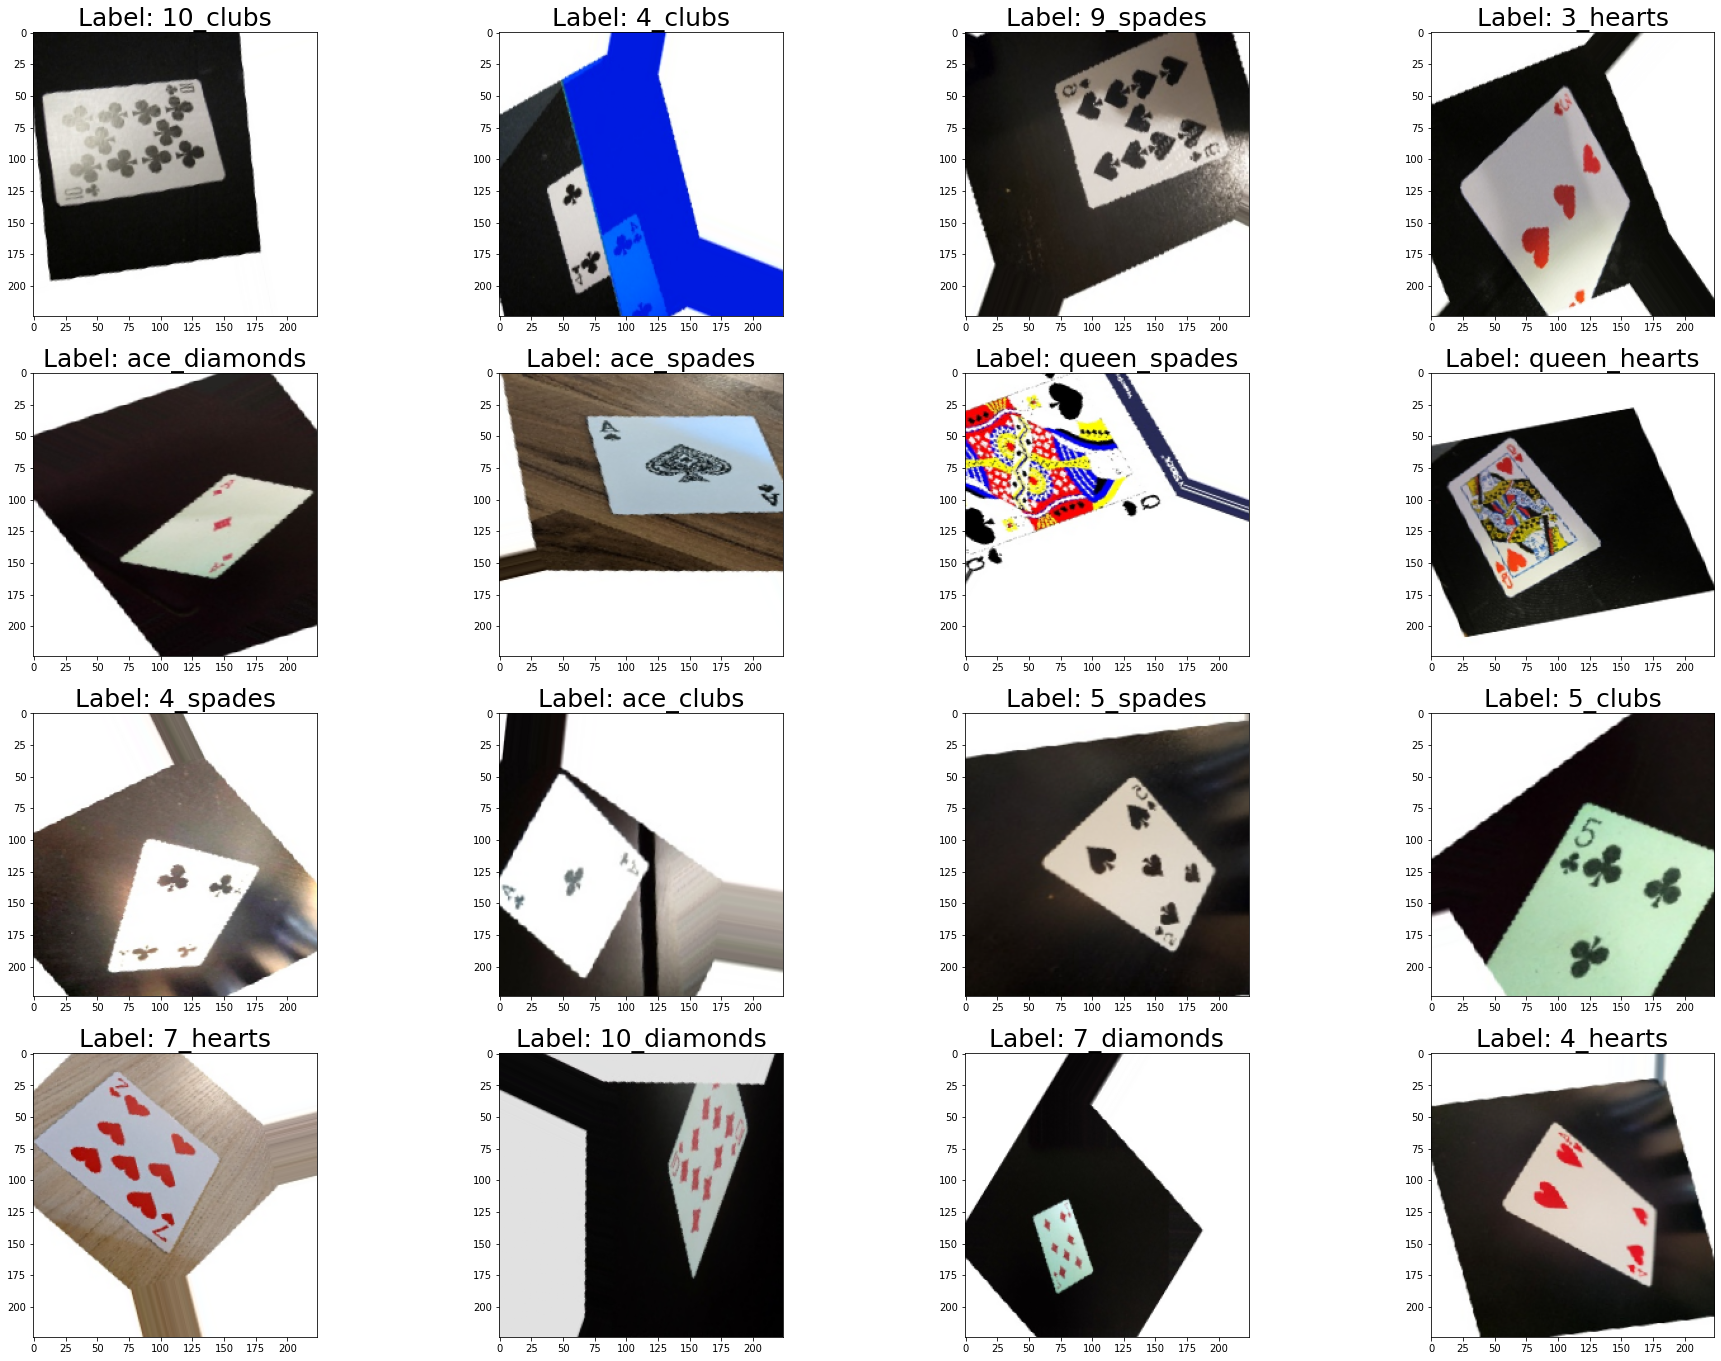

In [57]:
#Exploratory data analysis
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_generator.__getitem__(0)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [58]:
# Defining the model

trainable_flag = True
include_top_flag = False
weigths_value = 'imagenet'

if trainable_flag:
    include_top_flag = True
    weigths_value = None
else:
    include_top_flag = False
    weigths_value = 'imagenet'    


In [59]:
print(weigths_value)
print(include_top_flag)
print(trainable_flag)

base_model = tf.keras.applications.EfficientNetB0(
    weights=weigths_value, 
    include_top=include_top_flag,
    classes=len(classes_names))

None
True
True


In [60]:
inputs = layers.Input(shape=(img_height,img_width,3))
outputs = tf.keras.applications.EfficientNetB0(include_top=include_top_flag, weights=weigths_value,drop_connect_rate=0.3, classes=len(classes_names))(inputs)
model = tf.keras.Model( inputs,  outputs)

In [61]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________
None


In [62]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), #
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [577]:
model = tf.keras.models.load_model(model_name_it)
model.summary()
#model.get_weights()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________


In [63]:
history_it = model.fit(train_generator, epochs=1000, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it,early_stop,lr_schedule,tensorboard_callback])

Epoch 1/1000
1560/1560 [==============================] - ETA: 0s - loss: 3.4576 - accuracy: 0.0677
Epoch 1: val_loss improved from inf to 2.82933, saving model to Outputs\Efficient_net_B0_it_52.h5
1560/1560 [==============================] - 406s 255ms/step - loss: 3.4576 - accuracy: 0.0677 - val_loss: 2.8293 - val_accuracy: 0.1139 - lr: 0.0010
Epoch 2/1000
1560/1560 [==============================] - ETA: 0s - loss: 2.5249 - accuracy: 0.1684
Epoch 2: val_loss improved from 2.82933 to 2.21545, saving model to Outputs\Efficient_net_B0_it_52.h5
1560/1560 [==============================] - 397s 254ms/step - loss: 2.5249 - accuracy: 0.1684 - val_loss: 2.2154 - val_accuracy: 0.2158 - lr: 0.0010
Epoch 3/1000
1560/1560 [==============================] - ETA: 0s - loss: 2.1075 - accuracy: 0.2701
Epoch 3: val_loss improved from 2.21545 to 2.10930, saving model to Outputs\Efficient_net_B0_it_52.h5
1560/1560 [==============================] - 397s 254ms/step - loss: 2.1075 - accuracy: 0.2701 - v

In [134]:
model.save('final_it_EfficientNetB0_52_96_percent_v2_last_model.h5')
np.save('efficientNetB0_history_96_v2.npy',history_it.history)


In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


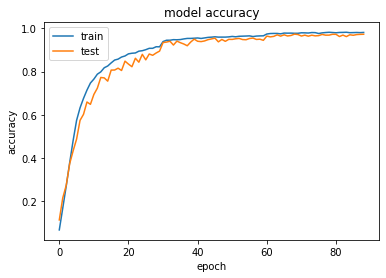

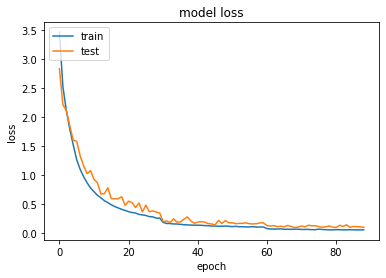

In [133]:
# list all data in history
print(history_it.history.keys())
# summarize history for accuracy
plt.plot(history_it.history['accuracy'])
plt.plot(history_it.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_it.history['loss'])
plt.plot(history_it.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('Outputs\Efficient_net_B0_it_52.h5')
model.save('final_it_EfficientNetB0_52_96_percent_v2_best_model.h5')

# Fine Tuning - with different augmentation

In [619]:
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "rotation_range":90,\
              "width_shift_range":0.2,\
              "height_shift_range":0.2, \
              "shear_range":0.2, \
              "zoom_range":0.2,\
              "vertical_flip":True,\
              "brightness_range": (0.1, 2)}

In [620]:
generator = ImageDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [27]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    shuffle = True,
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as training data

Found 24952 images belonging to 52 classes.


In [622]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as validation data

Found 6206 images belonging to 52 classes.


In [616]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 1e-6)

In [ ]:
history_ft = model.fit(train_generator, epochs=10, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it,early_stop,lr_schedule,tensorboard_callback])

In [ ]:
model.save('final_ft_EfficientNetB0_52_96_percent.h5')
np.save('efficientNetB0_history_96.npy',history_it.history)


In [632]:
#model = tf.keras.models.load_model('final_it_EfficientNetB0_52_90_percent.h5')

In [505]:
#model = tf.keras.models.load_model('Outputs/Efficient_net_B0_it_52.h5')

In [ ]:
%tensorboard --logdir 'Outputs/logs/fit'

# Testing

In [183]:
testgen = ImageDataGenerator()
test_generator = testgen.flow_from_directory(

    directory = 'dataset_test',
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    shuffle=False,
    #subset='validation',
    interpolation="nearest",
    classes=classes_names) # set as validation data
filenames = test_generator.filenames
nb_samples = len(filenames)

Found 7805 images belonging to 52 classes.


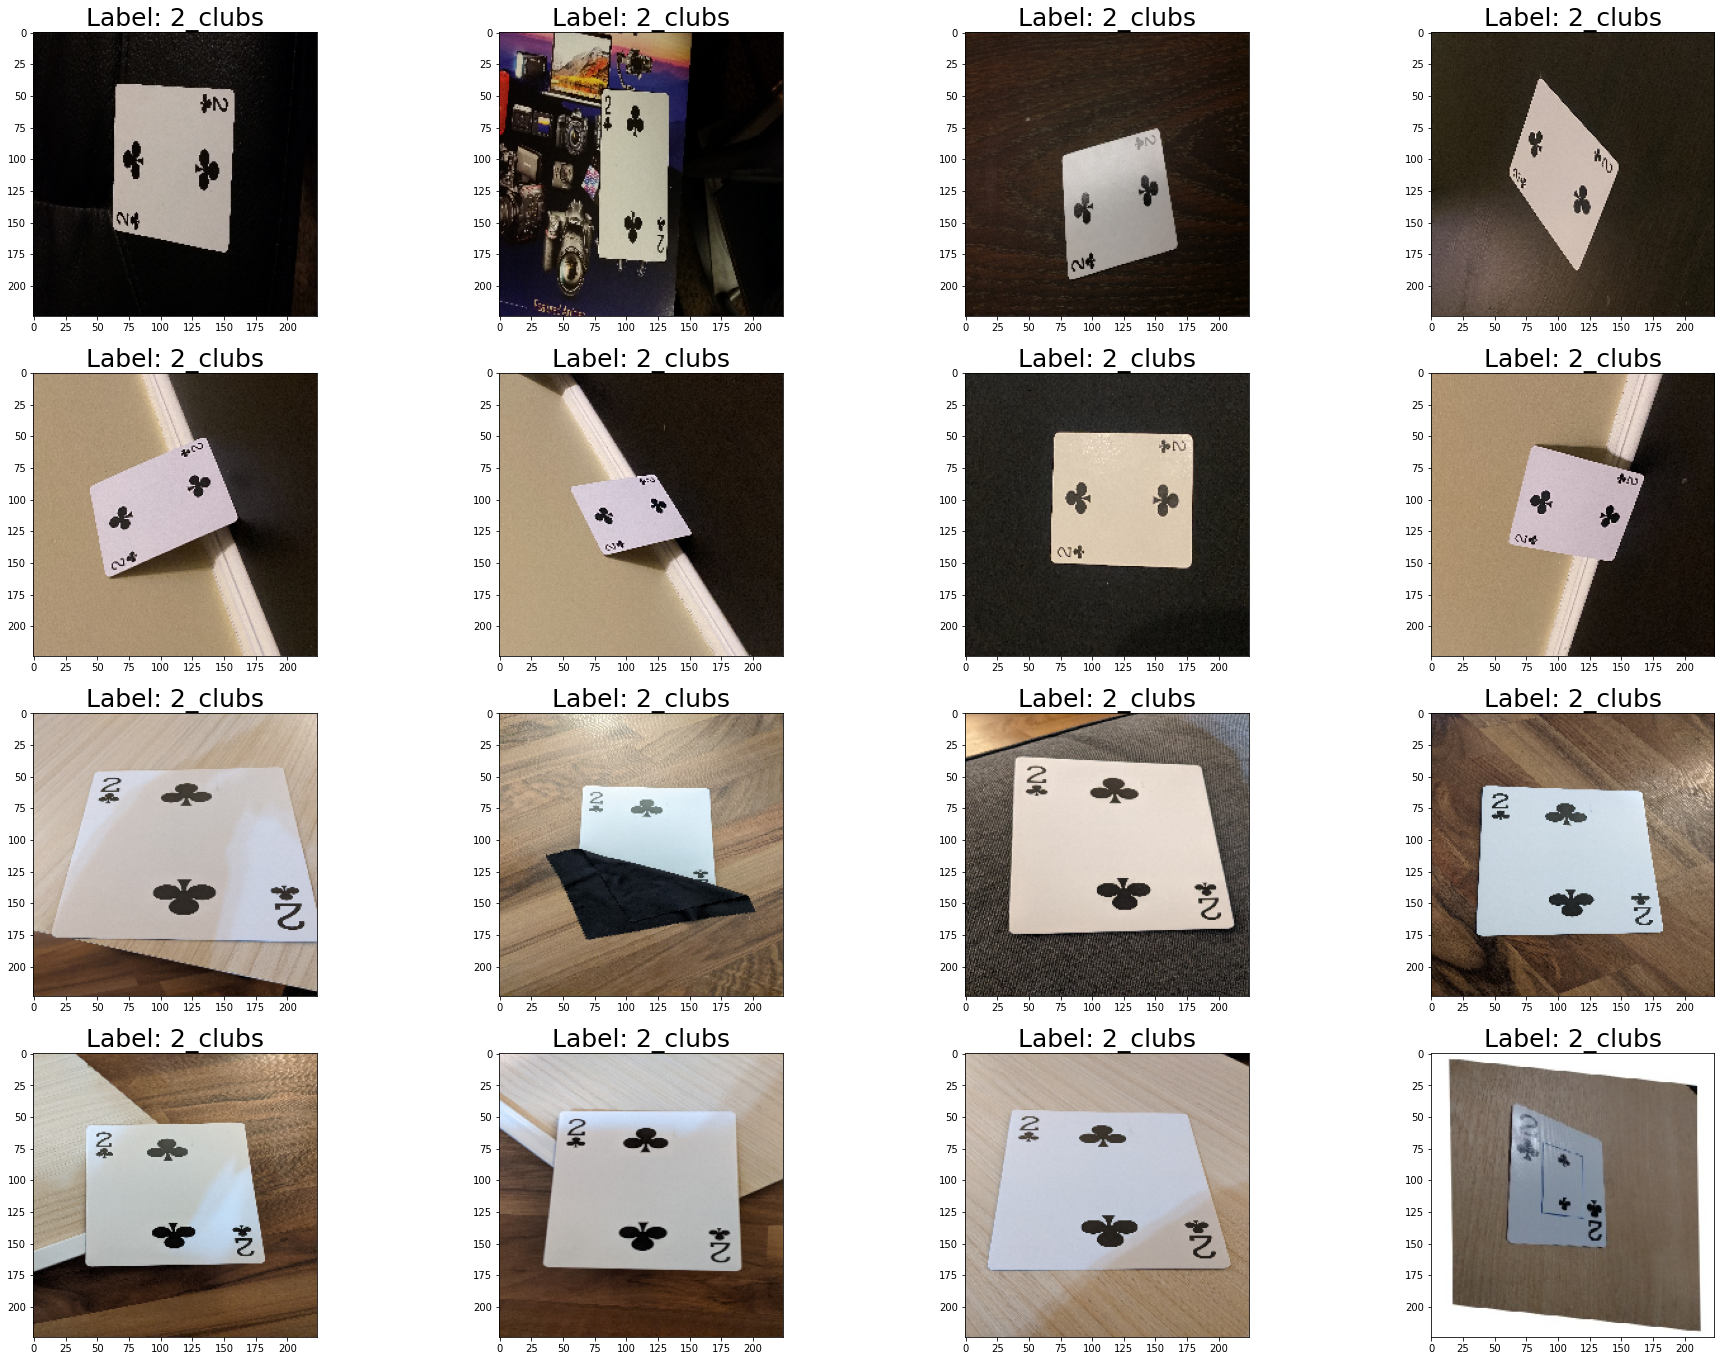

In [188]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = test_generator.__getitem__(1)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [185]:
predict = model.predict(test_generator, verbose = 1)


488/488 [==============================] - 117s 239ms/step


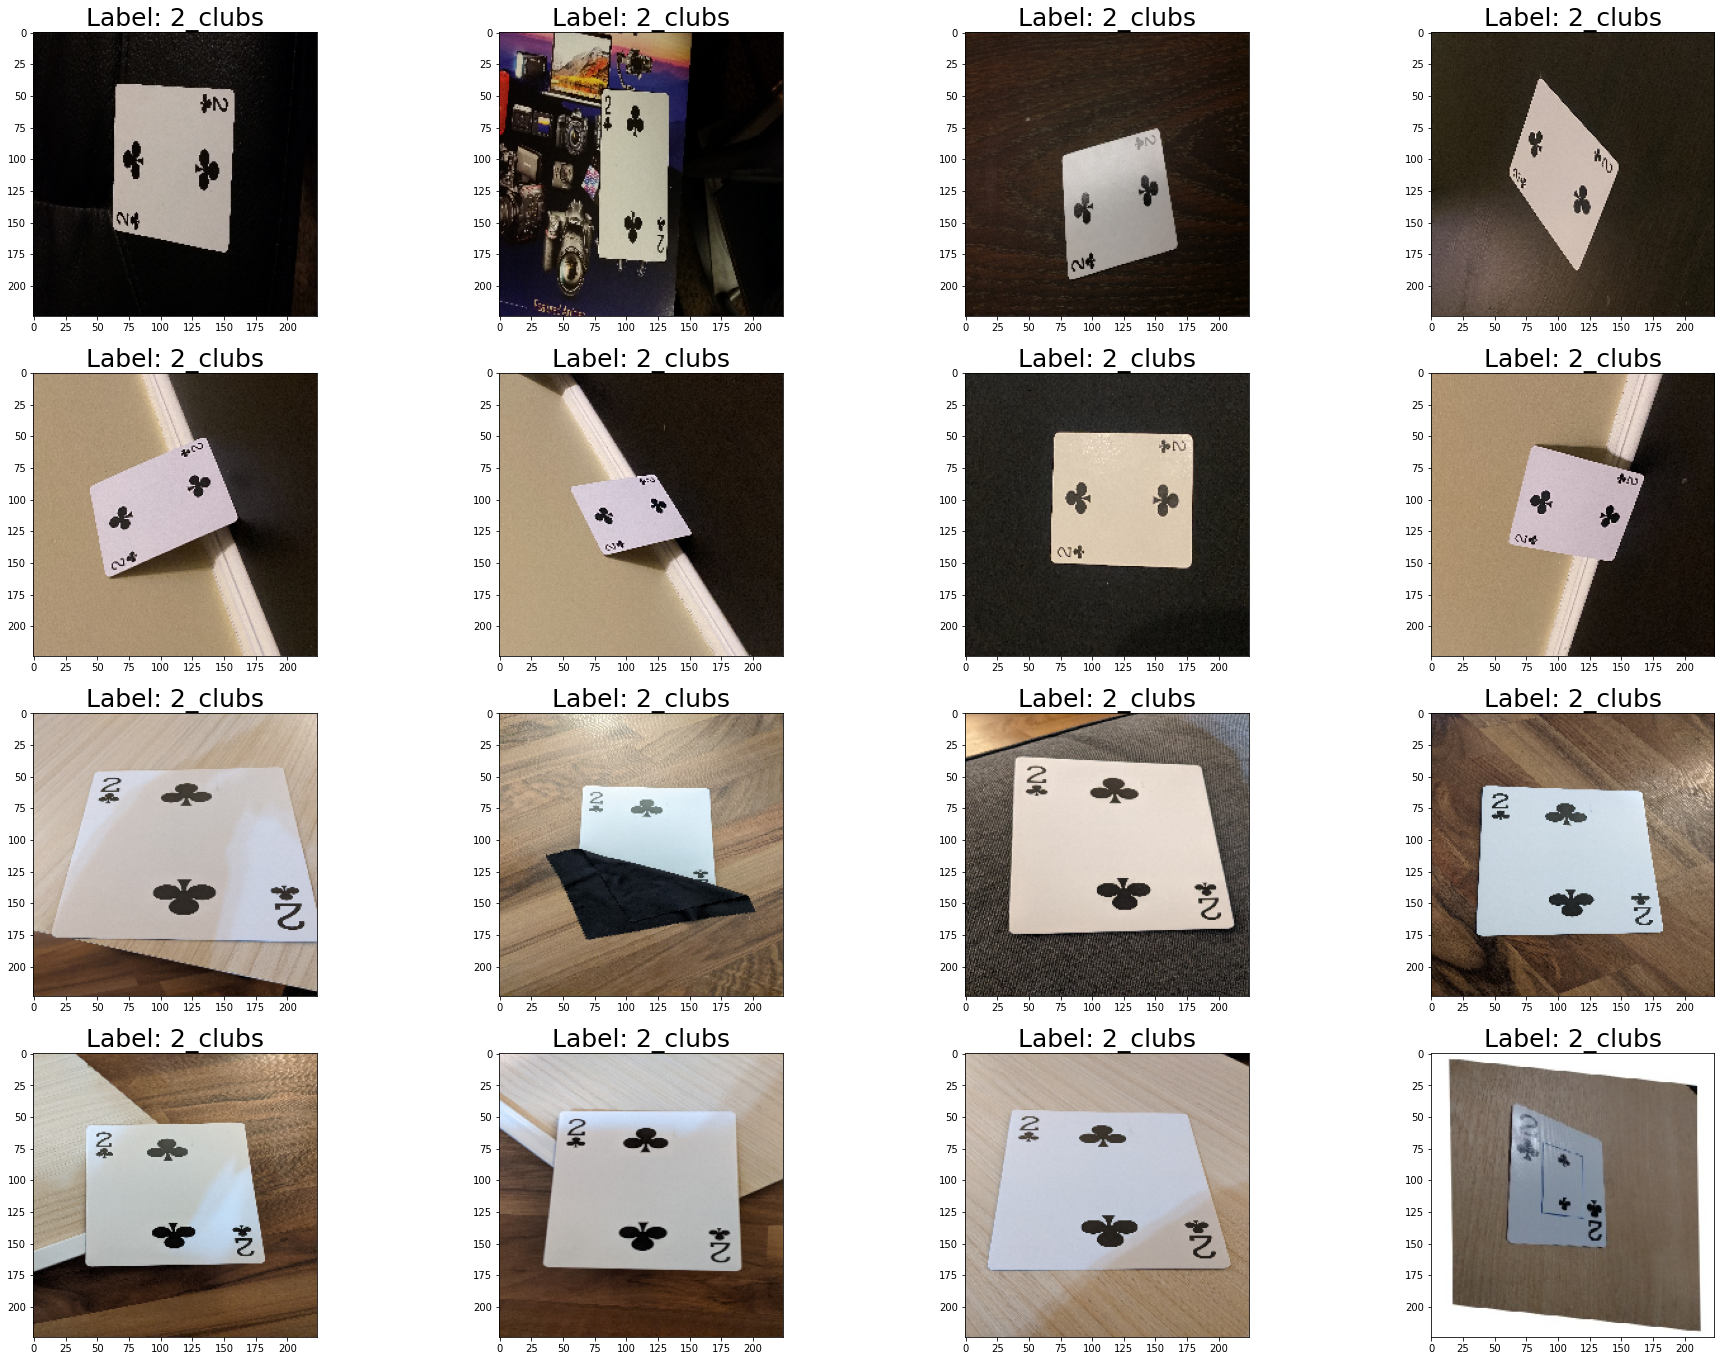

In [190]:
plt.figure(figsize = (32,24))
batch_num = 1
Xbatch,Ybatch = test_generator.__getitem__(batch_num)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(predict[ii +(batch_num*bs)].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()


In [135]:
eval = model.evaluate(test_generator, verbose = 1)


488/488 [==============================] - 112s 230ms/step - loss: 0.0975 - accuracy: 0.9760


In [138]:
import pandas as pd
pred_value = np.max(predict,axis = 1)
pred_idx = (np.argmax(predict,axis = 1)).astype(int).transpose()
pred_class = [classes_names[i] for i in pred_idx]
df = pd.DataFrame(data=pred_idx,columns= ['idx'])
df['pred_class'] = pred_class
df['pred_value'] =  pred_value
df['file_name'] = filenames
df.head()

idx pred_class  pred_value         file_name
0    0    2_clubs    0.988545    2_clubs\2C.png
1    0    2_clubs    0.999958   2_clubs\C21.jpg
2    0    2_clubs    0.999986  2_clubs\C210.jpg
3    0    2_clubs    0.999588   2_clubs\C22.jpg
4    0    2_clubs    0.998957   2_clubs\C25.jpg

## Single image test

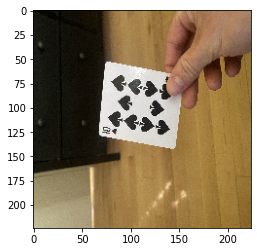

In [169]:
from keras.preprocessing import image
img_path  = "dataset_new_test/3.jpg"
img = image.load_img(img_path, target_size=(img_width, img_height))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])


In [172]:
pred = model.predict(images, batch_size=10, verbose =1)
print(classes_names[np.argmax(pred)],  pred[0][np.argmax(pred)],"%")

1/1 [==============================] - 0s 18ms/step
10_spades 0.9999987 %
